In [26]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten,Dropout
from sklearn.metrics import mean_absolute_error as mae
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
plt.rcParams['figure.figsize'] = [15,8]

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Thesis datasets/Monthly_Pharmaceutical_Sales.csv')
df.head()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
1,2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2,2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
3,2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
4,2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [4]:
df.tail()

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
65,2019-06-30,151.54,101.627,103.20,610.00,193.0,25.0,142.0,156.04
66,2019-07-31,181.00,103.541,92.80,649.80,250.6,20.0,115.0,105.20
67,2019-08-31,181.91,88.269,84.20,518.10,237.0,26.0,145.0,97.30
68,2019-09-30,161.07,111.437,93.50,984.48,227.8,16.0,161.0,109.10
69,2019-10-31,44.37,37.300,20.65,295.15,86.0,7.0,37.0,11.13


In [5]:
df.shape

(70, 9)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70 entries, 0 to 69
Data columns (total 9 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   datum   70 non-null     object 
 1   M01AB   70 non-null     float64
 2   M01AE   70 non-null     float64
 3   N02BA   70 non-null     float64
 4   N02BE   70 non-null     float64
 5   N05B    70 non-null     float64
 6   N05C    70 non-null     float64
 7   R03     70 non-null     float64
 8   R06     70 non-null     float64
dtypes: float64(8), object(1)
memory usage: 5.0+ KB


In [7]:
time = pd.date_range(start='1/31/2014',periods=70,freq='M')
df['time_stamp'] = pd.DataFrame(time)
df.drop('datum',axis=1,inplace=True)
df = df.set_index('time_stamp')

In [8]:
df.head()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
time_stamp,,,,,,,,
2014-01-31,127.69,99.090,152.100,878.030,354.0,50.0,112.0,48.2
2014-02-28,133.32,126.050,177.000,1001.900,347.0,31.0,122.0,36.2
2014-03-31,137.44,92.950,147.655,779.275,232.0,20.0,112.0,85.4
2014-04-30,113.10,89.475,130.900,698.500,209.0,18.0,97.0,73.7
2014-05-31,101.79,119.933,132.100,628.780,270.0,23.0,107.0,123.7


In [9]:
df.tail()

,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
time_stamp,,,,,,,,
2019-06-30,151.54,101.627,103.20,610.00,193.0,25.0,142.0,156.04
2019-07-31,181.00,103.541,92.80,649.80,250.6,20.0,115.0,105.20
2019-08-31,181.91,88.269,84.20,518.10,237.0,26.0,145.0,97.30
2019-09-30,161.07,111.437,93.50,984.48,227.8,16.0,161.0,109.10
2019-10-31,44.37,37.300,20.65,295.15,86.0,7.0,37.0,11.13


In [10]:
df = df[['N02BE']]
df

,N02BE
time_stamp,
2014-01-31,878.030
2014-02-28,1001.900
2014-03-31,779.275
2014-04-30,698.500
2014-05-31,628.780
...,...
2019-06-30,610.000
2019-07-31,649.800
2019-08-31,518.100


In [11]:
df = df + 1

In [12]:
df

,N02BE
time_stamp,
2014-01-31,879.030
2014-02-28,1002.900
2014-03-31,780.275
2014-04-30,699.500
2014-05-31,629.780
...,...
2019-06-30,611.000
2019-07-31,650.800
2019-08-31,519.100


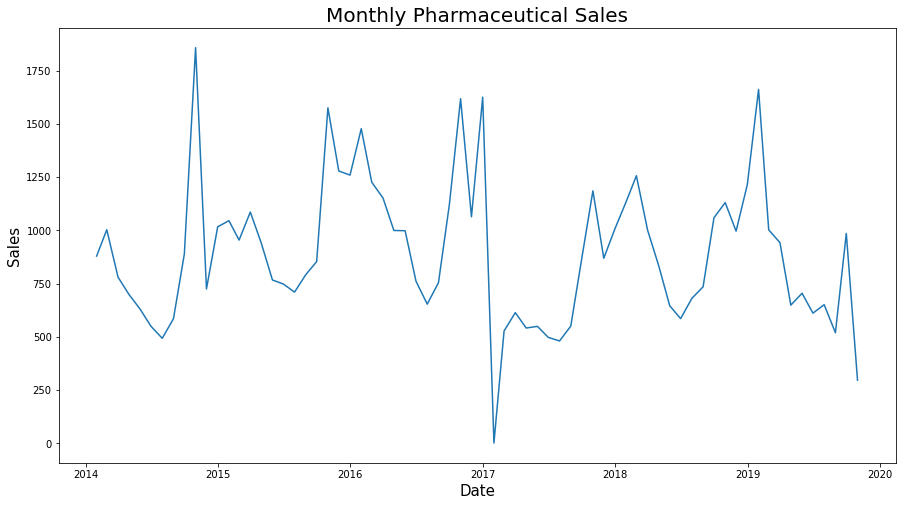

In [15]:
plt.plot(df)
plt.title('Monthly Pharmaceutical Sales',fontsize=20)
plt.xlabel('Date',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.show()

In [104]:
def convert2matrix(data_arr, look_back):
    X, Y =[], []
    for i in range(len(data_arr)-look_back):
        d=i+look_back  
        X.append(data_arr[i:d,0])
        Y.append(data_arr[d,0])
    return np.array(X), np.array(Y)

In [182]:
from sklearn.preprocessing import MinMaxScaler
#create numpy.ndarray 
df['N02BE'] = df['N02BE'].astype(np.float32)
df_arr = df.values
df_arr = np.reshape(df_arr, (-1, 1))
scaler = MinMaxScaler(feature_range=(0.1, 1))
df_arr = scaler.fit_transform(df_arr)

In [183]:
#Split data set into testing dataset and train dataset
train_size = 56
train, test =df_arr[0:train_size,:], df_arr[train_size:len(df_arr),:]
# setup look_back window 
look_back = 2
#convert dataset into right shape in order to input into the DNN
trainX, trainY = convert2matrix(train, look_back)
testX, testY = convert2matrix(test, look_back)

In [74]:
print(trainX.shape)
print(trainY.shape)
print(testX.shape)
print(testY.shape)

(54, 2)
(54,)
(12, 2)
(12,)


In [20]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 6.9 MB/s 


In [107]:
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner.tuners import RandomSearch
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,LeakyReLU
from tensorflow.keras.layers import Flatten
import matplotlib.pyplot as plt

In [22]:
def build_model(hp):
    model = keras.Sequential()
    for i in range(hp.Int('num_layers', 1, 10)):
        model.add(layers.Dense(units=hp.Int('units_' + str(i),
                                            min_value=8,
                                            max_value = 256,
                                            step=8),
                                            activation= "relu"))
        if hp.Boolean("dropout"):
          model.add(Dropout(hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(
        optimizer=keras.optimizers.Adam(
             hp.Float('learning_rate', min_value=1e-4, max_value=1e-1, sampling="log")),
        loss='mae',
        metrics=['mae'])
    return model

In [23]:
tuner = RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=20,
    executions_per_trial=1,
    directory='project',
    project_name='monthly_pharma')

In [24]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 10, 'step': 1, 'sampling': None}
units_0 (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 256, 'step': 8, 'sampling': None}
dropout (Boolean)
{'default': False, 'conditions': []}
learning_rate (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [25]:
tuner.search(trainX, trainY,
             epochs=200,
             batch_size=35,
             validation_data=(testX, testY))

Trial 20 Complete [00h 00m 07s]
val_mae: 0.13620872795581818

Best val_mae So Far: 0.09573664516210556
Total elapsed time: 00h 03m 05s
INFO:tensorflow:Oracle triggered exit


In [32]:
tuner.results_summary()

Results summary
Results in project/monthly_pharma
Showing 10 best trials
Trial summary
Hyperparameters:
num_layers: 9
units_0: 224
dropout: True
learning_rate: 0.002756039650304939
units_1: 8
units_2: 32
units_3: 192
units_4: 224
units_5: 40
units_6: 224
units_7: 184
units_8: 48
Dropout_rate: 0.1
units_9: 96
Score: 0.09573664516210556
Trial summary
Hyperparameters:
num_layers: 6
units_0: 176
dropout: True
learning_rate: 0.007554282210994538
units_1: 192
units_2: 16
units_3: 32
units_4: 8
units_5: 168
units_6: 72
units_7: 72
units_8: 192
Dropout_rate: 0.1
units_9: 72
Score: 0.09819366782903671
Trial summary
Hyperparameters:
num_layers: 4
units_0: 24
dropout: False
learning_rate: 0.01005043500811337
units_1: 64
units_2: 184
units_3: 168
units_4: 256
units_5: 224
units_6: 16
units_7: 216
units_8: 96
Dropout_rate: 0.30000000000000004
units_9: 152
Score: 0.09932515025138855
Trial summary
Hyperparameters:
num_layers: 9
units_0: 224
dropout: False
learning_rate: 0.03735801816240572
units_1: 8

In [29]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
# Build the model.
# Needed for `Sequential` without specified `input_shape`.
best_model.build(input_shape=(None, 2))
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 224)               672       
                                                                 
 dropout (Dropout)           (None, 224)               0         
                                                                 
 dense_1 (Dense)             (None, 8)                 1800      
                                                                 
 dropout_1 (Dropout)         (None, 8)                 0         
                                                                 
 dense_2 (Dense)             (None, 32)                288       
                                                                 
 dropout_2 (Dropout)         (None, 32)                0         
                                                                 
 dense_3 (Dense)             (None, 192)               6

In [37]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import EarlyStopping

In [184]:
model = Sequential()
model.add(Dense(32,input_dim = 2,activation='relu'))
model.add(Dense(16,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(1,activation='linear'))
ad=optimizers.Adam(learning_rate = 0.00001756039650304939)
model.compile(optimizer = ad, loss = 'mae', metrics = ['mae'])
model_history=model.fit(trainX, trainY,validation_data=(testX,testY), batch_size = 35, epochs = 1000,callbacks=[EarlyStopping(monitor='val_loss', patience=350)])

Epoch 1/1000
2/2 [==============================] - 1s 285ms/step - loss: 0.5436 - mae: 0.5436 - val_loss: 0.5233 - val_mae: 0.5233
Epoch 2/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.5431 - mae: 0.5431 - val_loss: 0.5228 - val_mae: 0.5228
Epoch 3/1000
2/2 [==============================] - 0s 36ms/step - loss: 0.5426 - mae: 0.5426 - val_loss: 0.5223 - val_mae: 0.5223
Epoch 4/1000
2/2 [==============================] - 0s 46ms/step - loss: 0.5421 - mae: 0.5421 - val_loss: 0.5218 - val_mae: 0.5218
Epoch 5/1000
2/2 [==============================] - 0s 40ms/step - loss: 0.5416 - mae: 0.5416 - val_loss: 0.5213 - val_mae: 0.5213
Epoch 6/1000
2/2 [==============================] - 0s 53ms/step - loss: 0.5411 - mae: 0.5411 - val_loss: 0.5208 - val_mae: 0.5208
Epoch 7/1000
2/2 [==============================] - 0s 41ms/step - loss: 0.5406 - mae: 0.5406 - val_loss: 0.5203 - val_mae: 0.5203
Epoch 8/1000
2/2 [==============================] - 0s 38ms/step - loss: 0.5401 - 

In [185]:
def model_loss(history):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(loc='upper right')
    plt.show();

In [186]:
trainX_2 = scaler.inverse_transform(trainX)
trainY_2 = scaler.inverse_transform([trainY])
testX_2 = scaler.inverse_transform(testX)
testY_2 = scaler.inverse_transform([testY])
train_score_2 = model.evaluate(trainX_2, trainY_2.reshape(-1,),verbose=0)
test_score_2 = model.evaluate(testX_2, testY_2.reshape(-1,),verbose=0)

Train MAE: 221.081991629095
Test MAE: 212.0556466881109


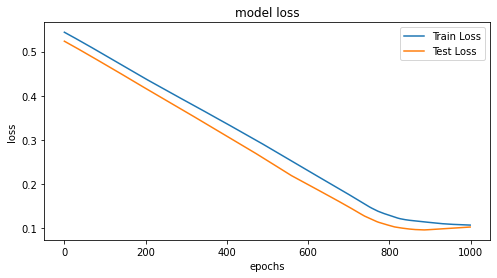

In [187]:
train_predict = model.predict(trainX)
test_predict = model.predict(testX)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
trainY = scaler.inverse_transform([trainY])
test_predict = scaler.inverse_transform(test_predict)
testY = scaler.inverse_transform([testY])
print("Train MAE:",mae(trainY.reshape(-1,),train_predict.reshape(-1,)))
print("Test MAE:",mae(testY.reshape(-1,),test_predict.reshape(-1,)))
model_loss(model_history)

In [102]:
import seaborn as sns

In [188]:
def prediction_plot(testY, test_predict,look_back):
    len_prediction=[x for x in range(56,68)]
    plt.plot(trainY.reshape(-1,))
    plt.plot(len_prediction, testY.reshape(-1,), marker='.', label='actual')
    plt.plot(len_prediction, test_predict, 'g', label="prediction")
    plt.tight_layout()
    sns.despine(top=True)
    plt.subplots_adjust(left=0.07)
    plt.ylabel('Units', size=15)
    plt.xlabel('Time step', size=15)
    plt.legend(fontsize=15)
    plt.show()

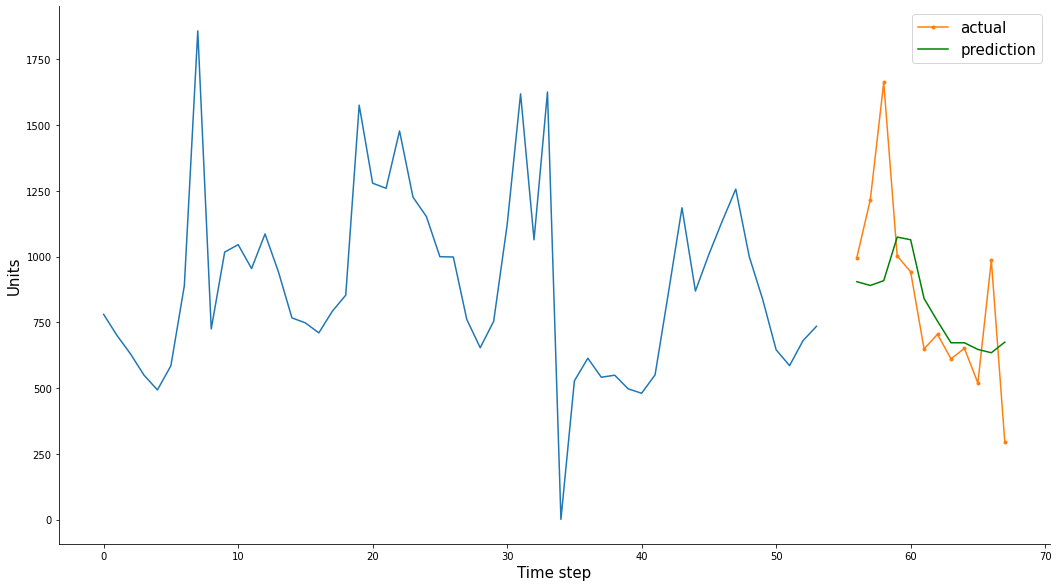

In [189]:
test_predict = model.predict(testX)
test_predict = scaler.inverse_transform(test_predict)
prediction_plot(testY, test_predict,look_back)